This step processes the .xml file of the annotations and produces a list of polygons (in the form of Shapely objects) extracted from the xml file. 

Annotated polygons are composed of 2 groups, labeled as '_0' and '_2' respectively. While there is no cited sources on the Camelyon website, upon cross-checking, we assume that '_0' represent polygons that denote 'Cancer', while there are regions within those tumors labeled as '_2' to denote non-cancerous tissues within a tumor. 

Then, the original is loaded to create tiles, and we check if each tile intersects with any cancerous regions (polygons). We produce a csv file containing the coordinates of the tiles as well as their labels: True means that the tile overlaps with the tumor polygons, False means that the tile does not overlap with a tumor polygon.

# Process XML

In [101]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon
from shapely.ops import cascaded_union
from shapely.strtree import STRtree
from shapely.geometry import MultiPolygon


In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.

In [58]:
tree = ET.parse('C:/harvard/capstone/test_046.xml') # TO EDIT if needed

In [59]:
# Convert these into X and Y by annotation groups

def get_coords(tree):
    """
    input: 
        tree: xml ElementTree object
    output: 
        polys: dictionary. key = annotation 0, 1, etc. value = polygon coordinates 
        groups: dictionary. key = annotation 0, 1, etc. value = partofgroup: _0 or _2
    """
    
    
    root = tree.getroot() #root element
    
    polys = {} # key = annotation 0, 1, etc. value = polygon coordinates 
    groups = {} # key = annotation 0, 1, etc. value = partofgroup: _0 or _2

    for item in root.findall('Annotations/Annotation'):

            # initialize for each Annotation group
            x_co = []
            y_co = []
            name = item.get('Name') #retuns: Annotation 0,1,2,...
            group = item.get('PartOfGroup') #returns: _0,_2

            for child in item.findall('Coordinates/Coordinate'):

                x = child.get('X') # returns: 0,1,2,
                x_co.append(x)
                y = child.get('Y') # returns: 0,1,2,
                y_co.append(y)

            # make into list of coords
            x_co = np.array(x_co,dtype=np.float32)
            y_co = np.array(y_co,dtype=np.float32)
            coo = list(zip(y_co,x_co))

            # save into dict
            polys[name] = coo
            groups[name] = group
    
    return polys, groups
    

In [60]:
# transform xml file into 2 dictionaries of polygon coords and annotations
polys, groups = get_coords(tree) 
# Create a group of polygon objects
polygons = [Polygon(polys[k]) for k in polys.keys()]

Below we inspect the content of the three variables: **polys, polygons, groups**

In [61]:
print('Number of polygons in this image:',len(polys))

Number of polygons in this image: 4


In [62]:
print('Overview of groups:',groups) #groups and their labels. _0 does seem to be the one WITH cancer

Overview of groups: {'Annotation 0': '_0', 'Annotation 1': '_0', 'Annotation 2': '_0', 'Annotation 3': '_0'}


In [63]:
# Count: cancer or no cancer? _0 is cancer, _2 is no cancer but within _0
Counter(groups.values()) 

Counter({'_0': 4})

# Load image

In [8]:
import pathml
from pathml import HESlide
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [9]:
wsi = HESlide("C:/harvard/capstone/test_046.tif", name = "test_046", backend = 'openslide')

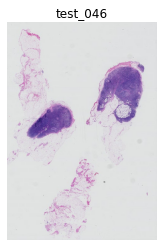

In [10]:
wsi.plot()

In [11]:
wsi.shape

(89600, 61440)

## Helper functions

In [65]:
# 1. check if a tile overlaps with a group of polygons

# before using this, inspect the type of polygons: _0(cancer) or _2(no cancer)
def tile_intersect_polys(query_geom,polygons):
    """
    This function checks if a tile overlaps with a group of polygons.
    query_geom: a polygon object(tile). e.g. Polygon([(30000, 30000), (40000, 30000), (40000, 40000), (30000, 40000)])
    polygons: a list of polygons(tumor). e.g. [Polygon(polys['Annotation 0']),...]
    """
    # create a shapely Tree object, but with query_geom
    s = STRtree([query_geom])
    # Returns a list of all geometries in the s(strtree) whose extents intersect the extent of multiple polygons
    multi = MultiPolygon(polygons)
    result = s.query(multi)
    # does my query_geom intersect with the polygon? True/False
    return query_geom in result

In [66]:
# 2. how to complete the tile coords: input tile initial coord and shape, output a full rectangular

# this will become the input of the query_geom
# output example: [(20000,20000), (30000, 20000), (30000,30000), (20000, 30000)]

def coords_expand(c,s,l):
    """
    c: tile.coords, e.g. (0,0)
    s: tile.shape, e.g. (3000,3000,3)
    l: level
    """
    l = 2**l
    ss = s[0] # e.g. 3000
    ans = [(c[0]*l,c[1]*l),((c[0]+ss)*l,c[1]*l),((c[0]+ss)*l,(c[1]+ss)*l),(c[0]*l,(c[1]+ss)*l)]
    return ans

## Check if tiles intersect with cancer regions

Here we have ignored the different annotation groups and assume that they will all represent tumors. @

In [67]:
# require previous variable: polygons
LEVEL = 1
SHAPE = 256

p_list = []  # to store a list of  rectangular polygon objects (tile)
p_coords = [] # to store coords of each tile
intersect = [] # to store if each tile intersects with any cancer polygons

for t in wsi.slide.generate_tiles(shape = SHAPE, level = LEVEL): #for each tile
    # generate tiles, make into query_geom
    coo = coords_expand(t.coords,t.shape,LEVEL)
    query_p = Polygon(coo) #tile(a polygon)
    p_coords.append(coo)
    # check if this tile intersect with the polygons
    intersect.append(tile_intersect_polys(query_p,polygons))
    p_list.append(query_p) #list of polygons


In [68]:
print('Number of tiles:',len(p_list))
print('Examples of tile list',p_list[:2])
print('Examples of tile coords',p_coords[:2])
print('Whether tiles intersect with polygons',intersect[:2])
print('How many tiles intersect with polygons:', sum(intersect))

Number of tiles: 21000
Examples of tile list [<shapely.geometry.polygon.Polygon object at 0x0000028F49099280>, <shapely.geometry.polygon.Polygon object at 0x0000028F490990D0>]
Examples of tile coords [[(0, 0), (512, 0), (512, 512), (0, 512)], [(0, 512), (512, 512), (512, 1024), (0, 1024)]]
Whether tiles intersect with polygons [False, False]
How many tiles intersect with polygons: 54


In [70]:
# export the result
dic = {'tile_coords': p_coords, 'tile_label': intersect}
df = pd.DataFrame(dic)
df.to_csv('test_046_tile_labels.csv')

(18432, 54272)
(18432, 54784)
(18432, 55296)
(18944, 54272)
(18944, 54784)
(18944, 55296)
(19456, 54272)
(19456, 54784)
(19456, 55296)
(19968, 54272)
(19968, 54784)
(19968, 55296)
(20480, 54272)
(20480, 54784)
(20480, 55296)
(20992, 54272)
(20992, 54784)
(20992, 55296)
(21504, 54272)
(21504, 54784)
(21504, 55296)
(22016, 54272)
(22016, 54784)
(22016, 55296)
(22528, 54272)
(22528, 54784)
(22528, 55296)
(23040, 54272)
(23040, 54784)
(23040, 55296)
(23552, 54272)
(23552, 54784)
(23552, 55296)
(24064, 54272)
(24064, 54784)
(24064, 55296)
(24576, 54272)
(24576, 54784)
(24576, 55296)
(25088, 54272)
(25088, 54784)
(25088, 55296)
(25600, 54272)
(25600, 54784)
(25600, 55296)
(26112, 54272)
(26112, 54784)
(26112, 55296)
(26624, 54272)
(26624, 54784)
(26624, 55296)
(27136, 54272)
(27136, 54784)


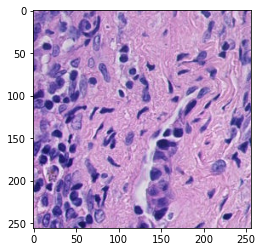

In [77]:
count=0
for i in range(len(p_coords)):
    if intersect[i]==True:
        media = wsi.slide.extract_region(location =(p_coords[i][0][0],p_coords[i][0][1]), level = LEVEL, size =(256,256))
        print(((p_coords[i][0][0],p_coords[i][0][1])))
        if count==52:
            plt.imshow(media)
            break
        count+=1

In [50]:
p_coords[20][0][1]

10240

## Plot

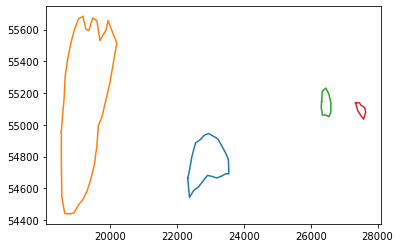

In [64]:
# plot: tumor
for p in polygons:
    plt.plot(*p.exterior.xy)

/var/folders/dv/bvvgqfdx65961yf27jjzsbb00000gn/T/ipykernel_10478/3892797650.py:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for t in tiles:


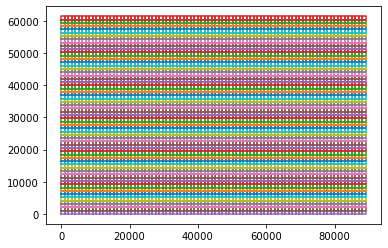

In [100]:
# multipolygon for tiles
tiles = MultiPolygon(p_list)

# plot: tumor with tiles
for p in polygons:
    plt.plot(*p.exterior.xy)
for t in tiles:
    plt.plot(*t.exterior.xy)
# hard to see because too many tiles

In [ ]:
# REF: 
# https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely
# https://shapely.readthedocs.io/en/stable/manual.html#polygons

In [6]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

In [7]:
# Let's check what we have
print(p1)
print(p2)
print(poly)


POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


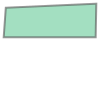

In [51]:
poly

In [41]:
p1.within(poly)

True

In [42]:
p2.within(poly)

False

In [48]:
# Does polygon contain p1?
poly.contains(p1)

True

In [49]:
# Does polygon contain p2?
poly.contains(p2)

False

In [ ]:
# Qn:
# how is each pixel represented? as a point? and to what resolution
# should be, because the array version is of that length. 
# how to make this process faster, any vectorization? 

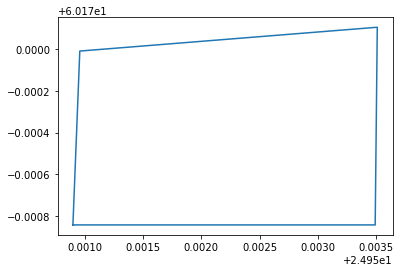

In [56]:
plt.plot(*poly.exterior.xy)
# but the coords seem wrong

In [57]:
type(poly)

shapely.geometry.polygon.Polygon

### Method 1

In [62]:
pip install rasterio

     |████████████████████████████████| 21.1 MB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


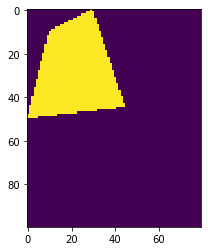

In [13]:
from shapely.geometry import Polygon
import rasterio.features
import matplotlib.pyplot as plt

poly = Polygon([(0, 50), (10, 10), (30, 0), (45, 45), (0, 50)])
img = rasterio.features.rasterize([poly], out_shape=(100, 80))
plt.imshow(img)


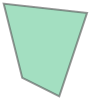

In [8]:
poly

In [9]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Method 2

In [9]:
import pylab as plt
import numpy as np
from matplotlib.path import Path

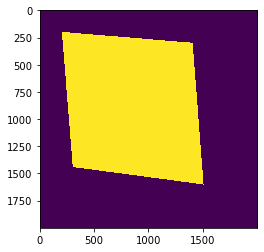

In [17]:
width, height=2000, 2000

polygon=[(0.1*width, 0.1*height), (0.15*width, 0.7*height), (0.8*width, 0.75*height), (0.72*width, 0.15*height)]
poly_path=Path(polygon)

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
plt.imshow(mask.reshape(height, width))
plt.show()

### Method 3

In [7]:
from PIL import Image, ImageDraw

width, height=2000, 2000
vertexlist = [(0.1*width, 0.1*height), (0.15*width, 0.7*height), (0.8*width, 0.75*height), (0.72*width, 0.15*height)]

img = Image.new('L', (width, height), 0)   # The Zero is to Specify Background Color
draw = ImageDraw.Draw(img)

for vertex in range(len(vertexlist)):
    startpoint = vertexlist[vertex]
    try: endpoint = vertexlist[vertex+1]
    except IndexError: endpoint = vertexlist[0] 
    # The exception means We have reached the end and need to complete the polygon
    draw.line((startpoint[0], startpoint[1], endpoint[0], endpoint[1]), fill=1)

# If you want the result as a single list
# You can make a two dimensional list or dictionary by iterating over the height and width variable
np.array(img.getdata())

# If you want the result as an actual Image
# img.save('polgon.jpg', 'JPEG')

array([0, 0, 0, ..., 0, 0, 0])

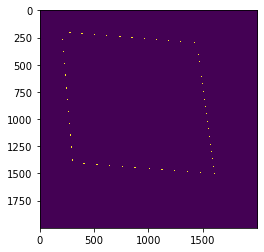

In [11]:
plt.imshow(img)

### Method 3.2

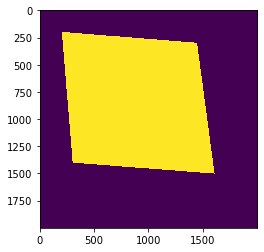

In [15]:
from PIL import Image, ImageDraw

width, height=2000, 2000
polygon = [(0.1*width, 0.1*height), (0.15*width, 0.7*height), (0.8*width, 0.75*height), (0.72*width, 0.15*height)]

img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = np.array(img)
plt.imshow(mask.reshape(height, width))
plt.show()

In [16]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

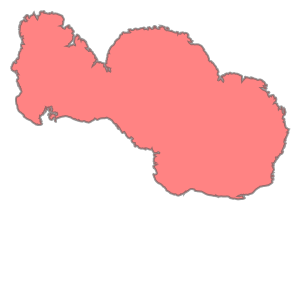

In [12]:
polygons[0]

### Method 1: failed

In [ ]:
# img = rasterio.features.rasterize([polygons[0]], out_shape=(100000,100000)) #wsi: (71680, 94208)
# plt.imshow(img)
# ^The above kills the kernel.

### Method 2: 

In [20]:
width, height=71680, 94208
polygon = polys['Annotation 0'] # [(1,1),(1,2),....]

In [ ]:
# original size: kernal dies
# shrink to level 2: by 2**2
width, height=width/(2^2), height/(2^2)
polygon = [(x/(2**2),y/(2**2)) for (x,y) in polygon] # [(1,1),(1,2),....]

In [ ]:
# poly_path=Path(polygon)

# x, y = np.mgrid[:height, :width]
# coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

# mask = poly_path.contains_points(coors)
# plt.imshow(mask.reshape(height, width))
# plt.show()

# Kernel crashed again

### Method 3.3: works with 1 polygon but taks a long time


In [10]:
from PIL import Image, ImageDraw

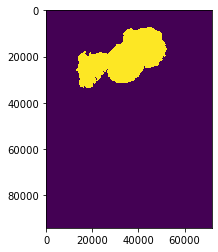

In [26]:
width, height=71680, 94208
polygon = polys['Annotation 0'] # [(1,1),(1,2),....]

img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = np.array(img)
plt.imshow(mask.reshape(height, width))
plt.show()

In [27]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
mask.shape

(94208, 71680)

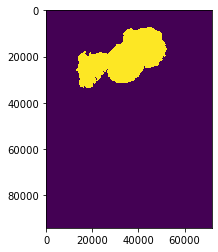

In [11]:
# multiple polygons
width, height=71680, 94208
polygon = polys['Annotation 0'] # [(1,1),(1,2),....]

img = Image.new('1', (width, height), 0)
# 1 (1-bit pixels, black and white, stored with one pixel per byte)
# L: (8-bit pixels, black and white)
# I (32-bit signed integer pixels)
# F (32-bit floating point pixels)
# check i
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = np.array(img,copy=False)
plt.imshow(mask.reshape(height, width))
plt.show()

In [ ]:
# 1. hd5 store in disks. process each annotation and put in h5. add to masks
# 2. stupid way: rewriting the same variable
# 3. scale down vertices, then pil.resize()
# 4. use 1-bit pixels
# 5. use a bounding box for the annotation, only label that. 
# 6. 

In [ ]:
# tile_size = 256 on level 2. test_046.tiff
# Presentation 9 Dec 9am. 
# p

In [ ]:
# initialize the mask: (all zeros)
wsi.h5['masks'].create_dataset('mask_name',dtype = 'float16', size = <size of maks i.e. image>)
# add annotation to mask:
wsi.h5['masks']['mask_name'][i_low:i_high,j_low:j_high] = mask_array

# in the pathml h5path: masks are stored in a group called 'masks'
# i_low and i_high are vertical boxes. 

In [ ]:
# access it directly:but may be too big to load to memory
wsi.h5['masks']['mask_name'][...] 

# or save it: to check with Haoyuan 
# 
SlideData.write()

# or: just try the stupid way of crossing all the tiles with Haoyuan 
# much easier to do 